### Import Libraries

In [1]:
# Import Libraries
import os
import time
import torch
import numpy as np
import torch.nn as nn
from torch import tensor
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory
from sklearn.metrics import roc_curve, auc
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchmetrics.classification import BinaryROC




cudnn.benchmark = True
plt.ion()   # interactive mode

### Main path to the whole dataset

In [2]:
main_directory = 'D:/CAD/skin_lesions'      # Set the path to the root directory of your dataset

### Apply data transformations and split the dataset to training, validation, test sets

In [3]:
# Data Normalization
data_transforms = {

    'train': transforms.Compose([
        transforms.Resize((224,224)),       # Resize each image to (224 x 224) pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize((224,224)),       # Resize each image to (224 x 224) pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize((224,224)),       # Resize each image to (224 x 224) pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



image_datasets = {x: ImageFolder(os.path.join(main_directory, x), data_transforms[x]) for x in ['train', 'val', 'test']}


# Create Data Loaders              
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4) for x in ['train', 'val','test']}
                                             
# Get Dataset size            
dataset_sizes = {x: len(image_datasets[x]) for x in ['train' , 'val','test']}
# Get The Categories
class_names = image_datasets['train'].classes


# Print the class labels
print(class_names)

['benign', 'malignant']


In [4]:
# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Function to train the model on the new dataset and finetune the new model using stochastic gradient descent

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs= 5):


    since = time.time() # Time at the beginning of training


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:


        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        # Save the best accuracy for later
        best_acc = 0.0

        # For each iteration/epoch perform training & validation phase
        for epoch in range(num_epochs):


            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:

                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode


                running_loss = 0.0      # Save the loss
                running_corrects = 0        # Correctly classified labels (total trues)


                # Iterate over data
                for inputs, labels in dataloaders[phase]:

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward, track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(inputs)
                        max_prob, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':        
                            loss.backward()
                            optimizer.step()


                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data) 
                    
                            
                                   
                if phase == 'train':
                    scheduler.step()

                
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                #epoch_loss = running_loss / dataset_sizes[phase]
                #print(f'{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    torch.save(model, 'D:/CAD/skin_lesion_alexnet.pkl')

    return model

### Modify the last layer of the pretrained model (transfer learning)

In [6]:
def transfer_learning(classes=2):
    alexnet_model = models.alexnet(pretrained=True)               # Use Alexnet without the last layer
    alexnet_model.classifier[6] = nn.Linear(4096, classes)             # Customize the last NN layer (consists of 4096 nodes)
    return alexnet_model

### Function to compute the evaluation metrics

In [7]:
def evaluation_metrics(true_positive, true_negative, false_positive, false_negative):
    
    recall = (true_positive) / (true_positive + false_negative)
    f1_score = (2 * true_positive) / ((2 * true_positive) + false_positive + false_negative)
    precision = (true_positive) / (true_positive + false_positive)
    specificity = (true_negative) / (true_negative + false_positive)
    informedness = recall + specificity - 1
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    print(f'Estimated recall: {recall}')
    print(f'Estimated f1_score: {f1_score}')
    print(f'Estimated Precision: {precision}')
    print(f'Estimated Specificity: {specificity}')
    print(f'Estimated Informedness: {informedness}')
    print(f'Estimated Accuracy: {accuracy}')

### Function to plot the ROC Curve

In [13]:
def plot_roc(pred_prob, true_labels):

    fpr_array = []
    tpr_array = []
    thresholds = np.linspace(0, 1, 1000)


    # Get predictions against each threshold per each class
    for threshold in thresholds:

        tp = sum([1 for prob, true_lbl in zip(pred_prob, true_labels) if (prob >= threshold) and (class_names[true_lbl] == 'malignant')])
        fp = sum([1 for prob, true_lbl in zip(pred_prob, true_labels) if (prob >= threshold) and (class_names[true_lbl] == 'benign')])
        tn = sum([1 for prob, true_lbl in zip(pred_prob, true_labels) if (prob < threshold) and (class_names[true_lbl] == 'benign')])
        fn = sum([1 for prob, true_lbl in zip(pred_prob, true_labels) if (prob < threshold) and (class_names[true_lbl] == 'malignant')])


        # We find the True positive rate and False positive rate based on the given threshold
        tpr = tp / (tp + fn)
        fpr = fp / (tn + fp)
        
        fpr_array.append(fpr)
        tpr_array.append(tpr)


    # Use Trapezoidal rule to calculate the area under the curve and approximating the intergral
    auc = np.trapz(np.array(fpr_array),np.array(tpr_array)) + 1

    plt.plot(fpr_array, tpr_array, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.title('Receiver Operating Characteristic for Binary class')
    plt.show()

### Function .....

In [9]:
def built_in_roc(metric = BinaryROC(), max_prob = [], labels_batch = [], thresholds = 100, initialize = False, plot = False):


    if initialize:
        # Calculate the ROC curve and AUC score
        metric = BinaryROC(thresholds = thresholds)
        return metric
        
    
    if plot == False:
        # Update the metric to compute the true positive and the false positive rates
        metric.update(max_prob, labels_batch)
        return metric

    elif plot == True:
        fig, ax = metric.plot(score=True)
        # Add a line with an angle of 45 degrees
        ax.plot(np.array([0, 1]), np.array([0, 1]), 'r-')
        # Set the aspect ratio of the plot to be equal
        ax.set_aspect('equal')
        # Display the plot
        plt.show()

### Test the model on the test dataset

In [10]:
def test_model(model):


    tp, tn, fp, fn = 0, 0, 0, 0          # true positive , true negative, false positive , false negative variables
    
    preds_array = []
    labels_array = []
    #metric = built_in_roc(thresholds = 100, initialize = True)



    with torch.no_grad():

        for inputs, labels_batch in dataloaders['test']:
            
            outputs = model(inputs)
            max_prob, preds = torch.max(outputs, 1)            
            standardized_probabilities = F.softmax(max_prob)        # Apply softmax to the output
            preds_array.extend(standardized_probabilities)
            labels_array.extend(labels_batch.data)
            #metric = built_in_roc(metric = metric, max_prob = max_prob, labels_batch = labels_batch)


            # Evaluate the model on the dataset
            tp += sum(1 for pred, true in zip(preds, labels_batch.data) if class_names[pred] == 'malignant' and class_names[true] == 'malignant')
            tn += sum(1 for pred, true in zip(preds, labels_batch.data) if class_names[pred] != 'malignant' and class_names[true] != 'malignant')
            fp += sum(1 for pred, true in zip(preds, labels_batch.data) if class_names[pred] == 'malignant' and class_names[true] != 'malignant')
            fn += sum(1 for pred, true in zip(preds, labels_batch.data) if class_names[pred] != 'malignant' and class_names[true] == 'malignant')
    

    evaluation_metrics(tp, tn, fp, fn)
    plot_roc(preds_array, labels_array)
    #built_in_roc(metric = metric, plot = True)

In [11]:
alexnet_model = transfer_learning().to(device)


# Criterion to evaluate the loss using cross entropy
criterion = nn.CrossEntropyLoss()
# Use Stochastic Gradient Descent as the optimizer with learning rate of 0.001 and momentum of 0.9
optimizer_ft = optim.SGD(alexnet_model.parameters(), lr = 0.001, momentum = 0.9)
# Decay LR by a factor of 0.1 every 7 epochs to help prevent the model from overfitting the training data
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)


alexnet_model = train_model(alexnet_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 40)

d:\IDEs\python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\IDEs\python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/39
----------

Epoch 1/39
----------

Epoch 2/39
----------

Epoch 3/39
----------

Epoch 4/39
----------

Epoch 5/39
----------

Epoch 6/39
----------

Epoch 7/39
----------

Epoch 8/39
----------

Epoch 9/39
----------

Epoch 10/39
----------

Epoch 11/39
----------

Epoch 12/39
----------

Epoch 13/39
----------

Epoch 14/39
----------

Epoch 15/39
----------

Epoch 16/39
----------

Epoch 17/39
----------

Epoch 18/39
----------

Epoch 19/39
----------

Epoch 20/39
----------

Epoch 21/39
----------

Epoch 22/39
----------

Epoch 23/39
----------

Epoch 24/39
----------

Epoch 25/39
----------

Epoch 26/39
----------

Epoch 27/39
----------

Epoch 28/39
----------

Epoch 29/39
----------

Epoch 30/39
----------

Epoch 31/39
----------

Epoch 32/39
----------

Epoch 33/39
----------

Epoch 34/39
----------

Epoch 35/39
----------

Epoch 36/39
----------

Epoch 37/39
----------

Epoch 38/39
----------

Epoch 39/39
----------

Training complete in 167m 50s
Best val Acc: 0.5790

C:\Users\saraa\AppData\Local\Temp\ipykernel_16424\2285320098.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  standardized_probabilities = F.softmax(max_prob)        # Apply softmax to the output


Estimated recall: 0.9733333333333334
Estimated f1_score: 0.8088642659279779
Estimated Precision: 0.6919431279620853
Estimated Specificity: 0.6388888888888888
Estimated Informedness: 0.6122222222222222
Estimated Accuracy: 0.7909090909090909


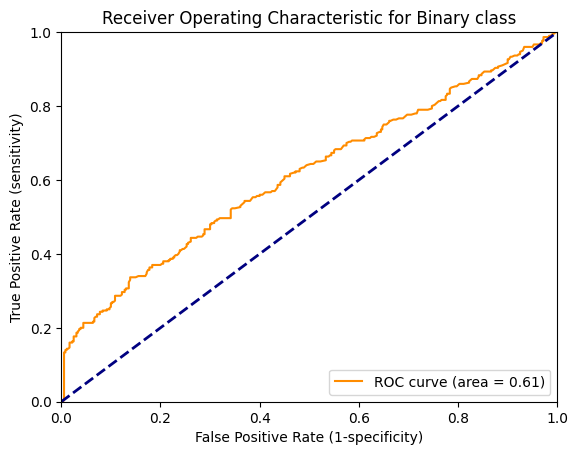

In [14]:
test_model(alexnet_model)